In [1]:
import os
import sys
import argparse
import torch
from getdist import plots, MCSamples
import getdist
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import collections  as mc
from scipy.stats import multivariate_normal

In [2]:
path = os.path.realpath(os.path.join(os.getcwd(), '../..'))
sys.path.insert(0, path)

In [3]:
from nnest.trainer import Trainer
from nnest.likelihoods import *
from nnest.priors import *

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [5]:
priors = [UniformPrior(2, -5, 5), UniformPrior(2, -2, 12), UniformPrior(2, -15, 15), UniformPrior(2, -3, 3)]
likes = [Gaussian(2, 0.9), Rosenbrock(2), Eggbox(2), GaussianShell(2)]

In [6]:
np.random.seed(0)

In [7]:
num_samples = 1000
samples = np.empty((len(likes), num_samples, 2))
for i, like in enumerate(likes):
    samples[i, :, :] = like.sample(priors[i], num_samples)

In [8]:
ng = 30
xx, yy = np.linspace(-4,4, ng), np.linspace(-4,4, ng)
xv, yv = np.meshgrid(xx, yy)
xy = np.stack([xv, yv], axis=-1)
in_circle = np.sqrt((xy**2).sum(axis=2)) <= 3
xy = xy.reshape((ng*ng, 2))
xy = torch.from_numpy(xy.astype(np.float32))

In [9]:
xs = np.empty((len(likes), 3, ng**2, 2))
best_loss = np.empty((len(likes), 3))
for i, like in enumerate(likes):
    flows = [
        Trainer(like.x_dim, flow='choleksy', learning_rate=0.001), 
        Trainer(like.x_dim, hidden_dim=64,  num_blocks=5, flow='nvp'),
        Trainer(like.x_dim, hidden_dim=16,  num_blocks=3, flow='spline')
    ]
    for j, flow in enumerate(flows):
        flow.train(np.squeeze(samples[i]), jitter=0.01)
        xs[i, j] = flow.get_samples(xy)
        best_loss[i, j] = flow.best_validation_loss

[nnest.trainer] [INFO] SingleSpeedCholeksy(
  (flow): NormalizingFlow(
    (flows): ModuleList(
      (0): Choleksy()
    )
  )
)
[nnest.trainer] [INFO] Number of network params: [5]
[nnest.trainer] [INFO] Device [cpu]
[nnest.trainer] [INFO] SingleSpeedNVP(
  (flow): NormalizingFlow(
    (flows): ModuleList(
      (0): CouplingLayer(
        (scale_net): Sequential(
          (0): Linear(in_features=2, out_features=64, bias=True)
          (1): Tanh()
          (2): Linear(in_features=64, out_features=64, bias=True)
          (3): Tanh()
          (4): Linear(in_features=64, out_features=64, bias=True)
          (5): Tanh()
          (6): Linear(in_features=64, out_features=2, bias=True)
        )
        (translate_net): Sequential(
          (0): Linear(in_features=2, out_features=64, bias=True)
          (1): ReLU()
          (2): Linear(in_features=64, out_features=64, bias=True)
          (3): ReLU()
          (4): Linear(in_features=64, out_features=64, bias=True)
          (5): 

[nnest.trainer] [INFO] Epoch [300] train loss [0.0203] validation loss [0.0200]
[nnest.trainer] [INFO] Epoch [350] train loss [0.0201] validation loss [0.0198]
[nnest.trainer] [INFO] Epoch [400] train loss [0.0201] validation loss [0.0198]
[nnest.trainer] [INFO] Epoch [450] train loss [0.0201] validation loss [0.0198]
[nnest.trainer] [INFO] Epoch [500] train loss [0.0200] validation loss [0.0198]
[nnest.trainer] [INFO] Epoch [550] train loss [0.0200] validation loss [0.0197]
[nnest.trainer] [INFO] Epoch [600] train loss [0.0201] validation loss [0.0197]
[nnest.trainer] [INFO] Epoch [644] ran out of patience
[nnest.trainer] [INFO] Best epoch [594] validation loss [0.0197]
[nnest.trainer] [INFO] Number of training samples [1000]
[nnest.trainer] [INFO] Training jitter [0.0100]
[nnest.trainer] [INFO] Epoch [1] train loss [0.0285] validation loss [0.0287]
[nnest.trainer] [INFO] Epoch [50] train loss [0.0200] validation loss [0.0202]
[nnest.trainer] [INFO] Epoch [100] train loss [0.0200] val

[nnest.trainer] [INFO] Number of network params: [5844]
[nnest.trainer] [INFO] Device [cpu]
[nnest.trainer] [INFO] Number of training samples [1000]
[nnest.trainer] [INFO] Training jitter [0.0100]
[nnest.trainer] [INFO] Epoch [1] train loss [0.0477] validation loss [0.0553]
[nnest.trainer] [INFO] Epoch [50] train loss [0.0311] validation loss [0.0341]
[nnest.trainer] [INFO] Epoch [100] train loss [0.0272] validation loss [0.0290]
[nnest.trainer] [INFO] Epoch [150] train loss [0.0257] validation loss [0.0273]
[nnest.trainer] [INFO] Epoch [200] train loss [0.0246] validation loss [0.0262]
[nnest.trainer] [INFO] Epoch [250] train loss [0.0238] validation loss [0.0254]
[nnest.trainer] [INFO] Epoch [300] train loss [0.0231] validation loss [0.0246]
[nnest.trainer] [INFO] Epoch [350] train loss [0.0226] validation loss [0.0240]
[nnest.trainer] [INFO] Epoch [400] train loss [0.0221] validation loss [0.0235]
[nnest.trainer] [INFO] Epoch [450] train loss [0.0218] validation loss [0.0230]
[nnest

[nnest.trainer] [INFO] SingleSpeedSpline(
  (flow): NormalizingFlow(
    (flows): ModuleList(
      (0): ActNorm()
      (1): Invertible1x1Conv()
      (2): NSF_CL(
        (f1): MLP(
          (net): Sequential(
            (0): Linear(in_features=1, out_features=16, bias=True)
            (1): LeakyReLU(negative_slope=0.2)
            (2): Linear(in_features=16, out_features=16, bias=True)
            (3): LeakyReLU(negative_slope=0.2)
            (4): Linear(in_features=16, out_features=16, bias=True)
            (5): LeakyReLU(negative_slope=0.2)
            (6): Linear(in_features=16, out_features=23, bias=True)
          )
        )
        (f2): MLP(
          (net): Sequential(
            (0): Linear(in_features=1, out_features=16, bias=True)
            (1): LeakyReLU(negative_slope=0.2)
            (2): Linear(in_features=16, out_features=16, bias=True)
            (3): LeakyReLU(negative_slope=0.2)
            (4): Linear(in_features=16, out_features=16, bias=True)
        

[nnest.trainer] [INFO] Epoch [550] train loss [0.0200] validation loss [0.0184]
[nnest.trainer] [INFO] Epoch [600] train loss [0.0193] validation loss [0.0186]
[nnest.trainer] [INFO] Epoch [650] train loss [0.0187] validation loss [0.0175]
[nnest.trainer] [INFO] Epoch [700] train loss [0.0180] validation loss [0.0170]
[nnest.trainer] [INFO] Epoch [750] train loss [0.0176] validation loss [0.0172]
[nnest.trainer] [INFO] Epoch [800] train loss [0.0174] validation loss [0.0156]
[nnest.trainer] [INFO] Epoch [850] train loss [0.0170] validation loss [0.0156]
[nnest.trainer] [INFO] Epoch [900] train loss [0.0166] validation loss [0.0152]
[nnest.trainer] [INFO] Epoch [950] train loss [0.0165] validation loss [0.0144]
[nnest.trainer] [INFO] Epoch [1000] train loss [0.0161] validation loss [0.0144]
[nnest.trainer] [INFO] Epoch [1050] train loss [0.0158] validation loss [0.0144]
[nnest.trainer] [INFO] Epoch [1087] ran out of patience
[nnest.trainer] [INFO] Best epoch [1037] validation loss [0.01

[nnest.trainer] [INFO] Number of network params: [5844]
[nnest.trainer] [INFO] Device [cpu]
[nnest.trainer] [INFO] Number of training samples [1000]
[nnest.trainer] [INFO] Training jitter [0.0100]
[nnest.trainer] [INFO] Epoch [1] train loss [0.0384] validation loss [0.0383]
[nnest.trainer] [INFO] Epoch [50] train loss [0.0357] validation loss [0.0357]
[nnest.trainer] [INFO] Epoch [100] train loss [0.0354] validation loss [0.0354]
[nnest.trainer] [INFO] Epoch [150] train loss [0.0353] validation loss [0.0354]
[nnest.trainer] [INFO] Epoch [200] train loss [0.0353] validation loss [0.0354]
[nnest.trainer] [INFO] Epoch [216] ran out of patience
[nnest.trainer] [INFO] Best epoch [166] validation loss [0.0354]
[nnest.trainer] [INFO] Number of training samples [1000]
[nnest.trainer] [INFO] Training jitter [0.0100]
[nnest.trainer] [INFO] Epoch [1] train loss [0.0363] validation loss [0.0355]
[nnest.trainer] [INFO] Epoch [50] train loss [0.0232] validation loss [0.0234]
[nnest.trainer] [INFO] E

In [10]:
print(best_loss)

[[ 0.01974484  0.01999001  0.02025576]
 [ 0.0218972  -0.00170393 -0.00176398]
 [ 0.07309867  0.03499651  0.01339162]
 [ 0.03539364  0.01853877  0.01656073]]


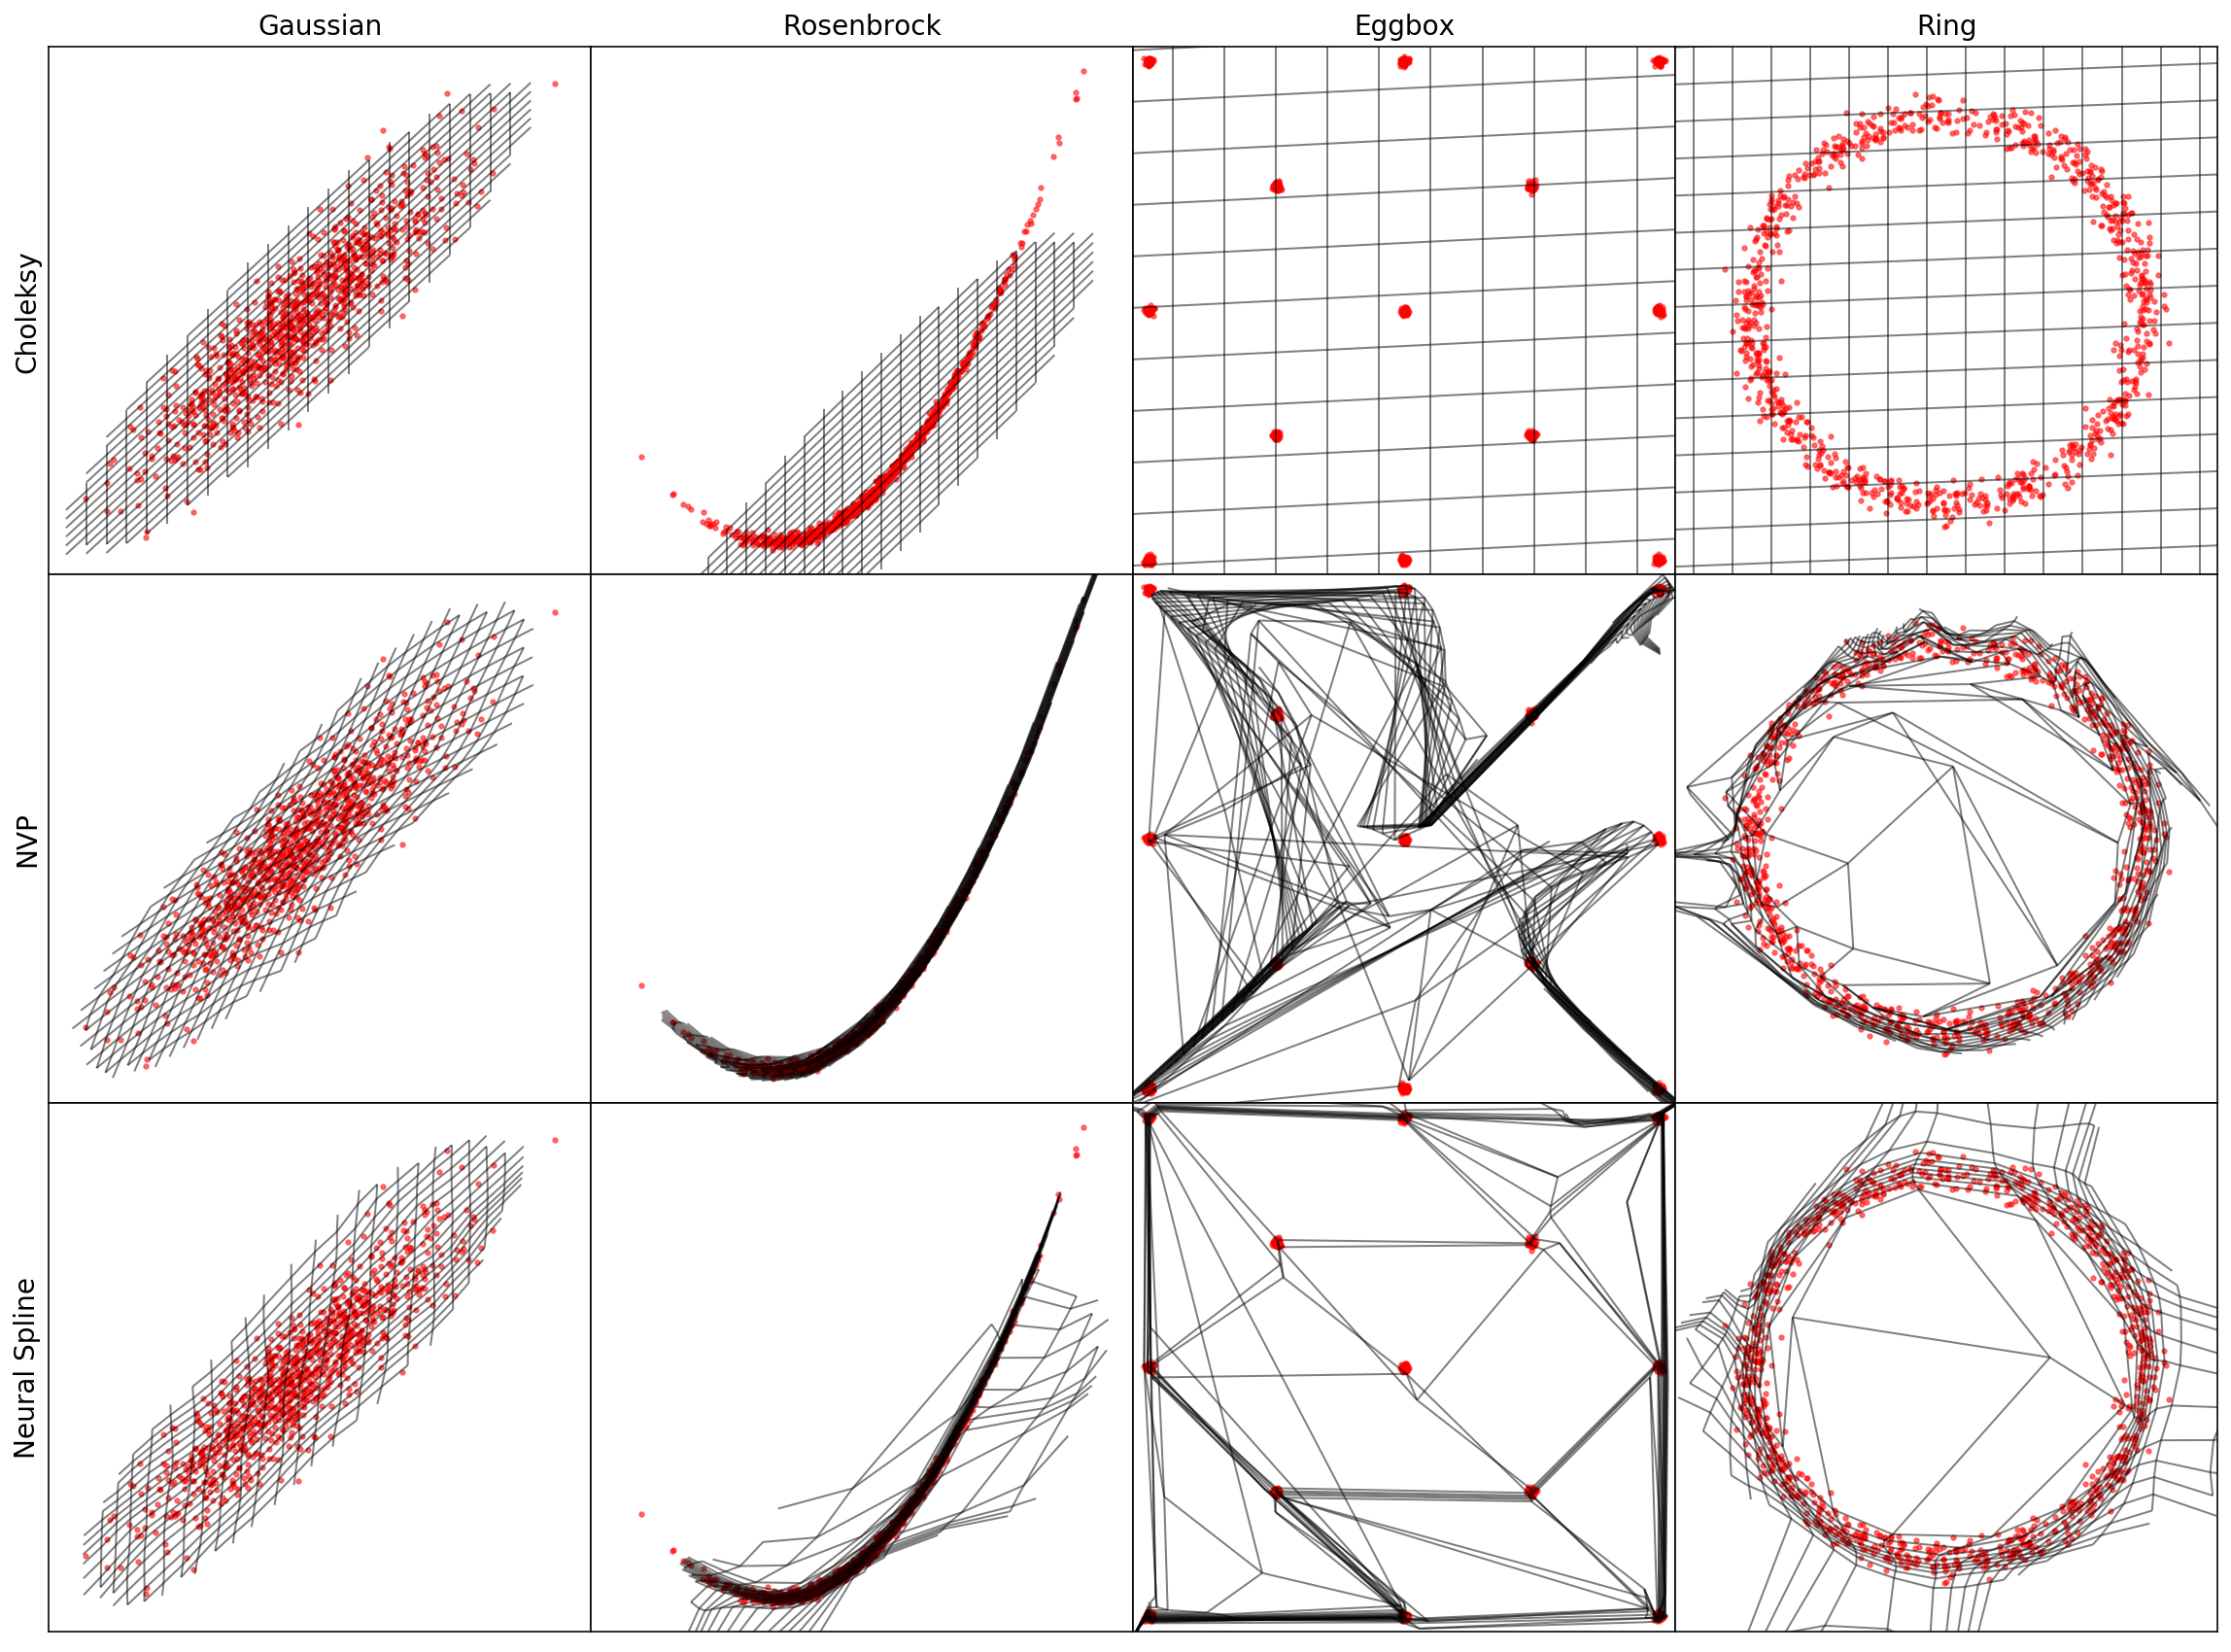

In [11]:
fig, ax = plt.subplots(3, 4, figsize=(20, 15)) 
fig.subplots_adjust(hspace=0, wspace=0)
for i in range(3): 
    for j in range(4): 
        x = xs[j, i].reshape((ng, ng, 2)) 
        p1 = np.reshape(x[1:,:,:], (ng**2-ng,2))
        p2 = np.reshape(x[:-1,:,:], (ng**2-ng,2))
        inc = np.reshape(in_circle[1:,:] | in_circle[:-1,:], (ng**2-ng,))
        p1, p2 = p1[inc], p2[inc]
        lcy = mc.LineCollection(zip(p1, p2), linewidths=1, alpha=0.5, color='k')
        p1 = np.reshape(x[:,1:,:], (ng**2-ng,2))
        p2 = np.reshape(x[:,:-1,:], (ng**2-ng,2))
        inc = np.reshape(in_circle[:,1:] | in_circle[:,:-1], (ng**2-ng,))
        p1, p2 = p1[inc], p2[inc]
        lcx = mc.LineCollection(zip(p1, p2), linewidths=1, alpha=0.5, color='k')
        ax[i,j].add_collection(lcy)
        ax[i,j].add_collection(lcx)
        ax[i,j].set_xlim([np.min(samples[j,:,0])-0.5,np.max(samples[j,:,0])+0.5])
        ax[i,j].set_ylim([np.min(samples[j,:,1])-0.5,np.max(samples[j,:,1])+0.5])
        ax[i,j].scatter(samples[j,:,0], samples[j,:,1], c='r', s=5, alpha=0.5)
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
ax[0,0].set_title('Gaussian', fontsize=14)
ax[0,1].set_title('Rosenbrock', fontsize=14)
ax[0,2].set_title('Eggbox', fontsize=14)
ax[0,3].set_title('Ring', fontsize=14)
ax[0,0].set_ylabel('Choleksy', fontsize=14)
ax[1,0].set_ylabel('NVP', fontsize=14)
ax[2,0].set_ylabel('Neural Spline', fontsize=14)
plt.show()